# Long Short-Term Memory (LSTM) for Sentiment Analysis
This notebook goes through the implementation of a Long Short Term Memory (LSTM) Recurrent Neural Network, for performing Sentiment Analysis on a set of Amazon Fine Food reviews.

### Table of contents

1. [Introduction](#Introduction)<br>
    1.1. [Long Short-Term Memory (LSTM)](#LSTM)<br>
    1.2. [Sentiment analysis](#Sentiment-analysis)
2. [Preparations](#Preparations)<br>
3. [Data](#Data)<br>
    3.1. [Load data](#Load-data)<br>
    3.2. [Choose Features](#Choose-features)<br>
    3.3. [Data Analysis](#Data-analysis)<br>
4. [Feature Engineering](#Feature-engineering)<br>
    4.1. [Preprocess Feature Vector](Preprocess-feature-vector)<br>
5. [Modelling](#Modelling)<br>
    5.1. [Build the Model](#Build-the-model)<br>
    5.2. [Analyze Results](#Analyze-results)<br>
    5.3. [Conclusions](#Conclusions)

## 1. Introduction <a id="Introduction"/>

### 1.1 Long Short-Term Memory (LSTM)  <a id="LSTM"/>
LSTM is a Recurrent Neural Network (RNN) architecture that provides a long term memory, in addition to the short term memory present in traditional RNNs. The ability to persist information over time, and learn long-term dependencies, allows LSTM to counteract an issue affecting traditional RNNs - known as the vanishing gradient problem. It is also this temporal dimension, which makes LSTMs a good fit for tasks involving time series data.

### 1.2 Sentiment analysis  <a id="Sentiment-analysis"/>
Sentiment Analysis is the use of Natural Language Processing techniques to identify, extract, and study the subjective information of a given text. In this notebook, sentiment analysis in used in order to predict the polarity – **positive**, **negative** or **neutral** – of a set of reviews.

## 2. Preparations <a id="Preparations"/>

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.model_selection import train_test_split
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import LSTM, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/william/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/william/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 3. Data <a id="Data"/>

The data used in this notebook is a set of reviews of fine foods from amazon. The dataset consists of 568,454 individual reviews, and can be found from the following address: <a href="https://www.kaggle.com/snap/amazon-fine-food-reviews">Amazon Fine Food Reviews</a>.

### 3.1 Load the dataset <a id="Load-data"/>

In [2]:
# Load dataset
df = pd.read_csv("data/reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### 3.2 Choose features <a id="Choose-features"/>
The data consists of 10 variables (Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary, Text). 

The sentiment analysis will be performed on variables "Score" and "Text".

* Text: Text of the review
* Score: Rating between 1 and 5

In [3]:
df = df[["Text", "Score"]]
df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### 3.3 Data analysis <a id="Data-analysis"/>
Perform explorative data analysis of the data. 

In [4]:
# Check if there are any empty values in the variables of interest
df[["Text", "Score"]].isnull().sum()

Text     0
Score    0
dtype: int64

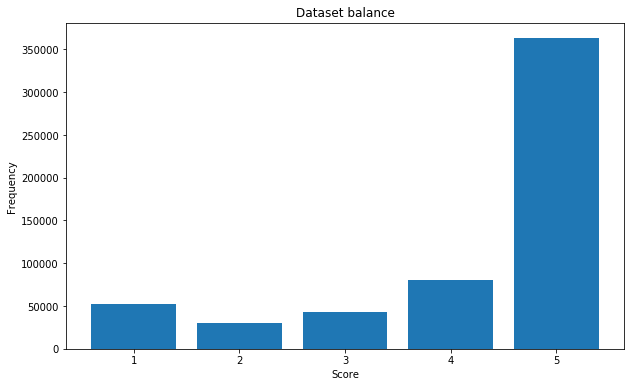

In [5]:
# Check if the dataset is balanced
(unique, counts) = np.unique(df["Score"], return_counts=True)
fig = plt.figure(figsize=(10,6))
plt.bar(unique, counts)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Dataset balance")
plt.show()

The data is not balanced. The overrepresentation of high scores could result in a model skewed towards making predictions in favor of the class representing high scores - i.e. positive reviews.

## 4. Feature engineering <a id="Feature-engineering"/>
The reviews (text) and ratings (score) are preprocessed and made into a feature- and a target vector.

### 4.1 Balance dataset  <a id="example1"/>

In [6]:
# Remove neutral reviews i.e. reviews with score 3.
df = df[df["Score"] != 3]
# Reviews with a score less than 3 are marked as 0 (negative) and reviews with a score higher than 3 are marked as 1 (positive)  
df["Score"] = df["Score"].apply(lambda x: 1 if x > 3 else 0)

In [7]:
# Create a balanced dataset
df_positive = df[df["Score"] == 1][:80000]
df_negative = df[df["Score"] == 0][:80000]
df = pd.concat([df_positive, df_negative])

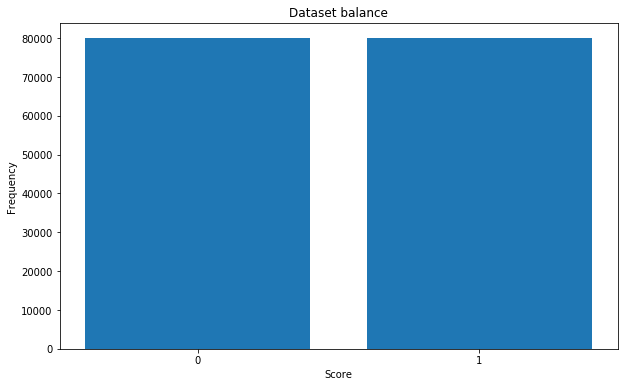

In [8]:
# Check that dataset is balanced
(unique, counts) = np.unique(df["Score"], return_counts=True)
fig = plt.figure(figsize=(10,6))
plt.bar(unique, counts)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Dataset balance")
plt.xticks([0,1])
plt.show()

In [9]:
# Create target vector
y = df["Score"]
y.head()

0    1
2    1
4    1
5    1
6    1
Name: Score, dtype: int64

### 4.2 Preprocess feature vector  <a id="Preprocess-feature-vector"/>

In [10]:
# Inspect one review
df["Text"].iloc[21]

'Product received is as advertised.<br /><br /><a href="http://www.amazon.com/gp/product/B001GVISJM">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>'

In [11]:
# Create a function for processing reviews
def preprocess_text(text):
    
    # Convert sentence to lowercase
    sentence = text.lower()
    
    # Remove emails
    sentence = re.sub(r"@[^\s]+", " ", sentence)
    
    # Remove URLs
    sentence = re.sub(r"((www\.[^\s]+)|(https?://[^\s]+))", " ", sentence)
    
    # Remove tags
    sentence = re.sub(r"<[^>]*>", " ", sentence)
    
    # Remove punctuations and numbers
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    
    # Remove single characters 
    sentence = re.sub(r"\s+[a-zA-Z]\s+", " ", sentence)
    
    # Remove multiple spaces
    sentence = re.sub(r"\s+", " ", sentence)
    
    # Remove stopwords (removal of stopwords impaired the model's performance, and was not implemented)
    # sw_tokens = word_tokenize(sentence)
    # tokens_without_sw = [word for word in sw_tokens if not word in stopwords.words("english")]
    # sentence = (" ").join(tokens_without_sw)
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemma_tokens = word_tokenize(sentence)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in lemma_tokens]
    sentence = (" ").join(lemmatized_tokens)
    
    return sentence

In [12]:
# Create the feature vector
X = df["Text"].apply(lambda x: preprocess_text(x))

In [13]:
# Inspect the review after it has been processed
X.iloc[21]

'product received is a advertised'

In [14]:
# Tokenize the feature variable (i.e. convert textual data into a numeric representation of the data)
tokenizer = Tokenizer(num_words=1000) # Set the maximum number of words to keep, based on the word frequency, to 5000
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [15]:
# Make sequences the same length by adding padding where needed
X = pad_sequences(X, padding="post", maxlen=200)

In [16]:
# Create a training and a test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [17]:
# Create word embeddings using the GloVe pretained model for twitter.
# For more information, see: https://nlp.stanford.edu/projects/glove/

# Create empty dictionary
embeddings_dict = dict()

# Create embedding vector
with open('data/glove.twitter.27B.200d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = vector

In [18]:
# Create embeddings matrix
embeddings_matrix = np.zeros((len(tokenizer.word_index) + 1, 200))
for word, index in tokenizer.word_index.items():
    embeddings_vector = embeddings_dict.get(word)
    if embeddings_vector is not None:
        embeddings_matrix[index] = embeddings_vector

## 5. Modelling <a id="Modelling"/>
Building the LSTM sentiment analysis model and evaluating the results.

### 5.1 Build the model <a id="Build-the-model"/>
Embedding -> LSTM -> Dropout -> LSTM -> Dropout -> Dense(Output(Sigmoid))

In [19]:
# Define model architecture and compile the model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 200, weights=[embeddings_matrix], input_length=X.shape[1], trainable=False))
model.add(LSTM(196, return_sequences=True))
model.add(Dropout(0.7))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.7))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          11300400  
_________________________________________________________________
lstm (LSTM)                  (None, 200, 196)          311248    
_________________________________________________________________
dropout (Dropout)            (None, 200, 196)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 128)          166400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
dense (Dense)                (None, 200, 1)            129       
Total params: 11,778,177
Trainable params: 477,777
Non-trainable params: 11,300,400
______________________________________

In [20]:
# Fit model on training data
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
3200/3200 [==============================] - 1154s 355ms/step - loss: 0.6400 - accuracy: 0.5920 - val_loss: 0.3326 - val_accuracy: 0.8491
Epoch 2/10
3200/3200 [==============================] - 1137s 355ms/step - loss: 0.3287 - accuracy: 0.8549 - val_loss: 0.2874 - val_accuracy: 0.8772
Epoch 3/10
3200/3200 [==============================] - 2886s 902ms/step - loss: 0.2669 - accuracy: 0.8848 - val_loss: 0.2607 - val_accuracy: 0.8894
Epoch 4/10
3200/3200 [==============================] - 3602s 1s/step - loss: 0.2349 - accuracy: 0.9003 - val_loss: 0.3736 - val_accuracy: 0.8201
Epoch 5/10
3200/3200 [==============================] - 2864s 895ms/step - loss: 0.2012 - accuracy: 0.9156 - val_loss: 0.2565 - val_accuracy: 0.8967
Epoch 6/10
3200/3200 [==============================] - 4076s 1s/step - loss: 0.1742 - accuracy: 0.9278 - val_loss: 0.2390 - val_accuracy: 0.9030
Epoch 7/10
3200/3200 [==============================] - 2861s 894ms/step - loss: 0.1496 - accuracy: 0.9378 - val

### 5.2 Analyze the result <a id="Analyze-the-results"/>

In [21]:
# Evaluate model on test data
results = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", results[0])
print("Test Accuracy:", results[1])
print("Accuracy: %.2f%%" % (results[1] * 100))

1000/1000 [==============================] - 119s 119ms/step - loss: 0.2952 - accuracy: 0.9036
Test Score: 0.2952086329460144
Test Accuracy: 0.9036359190940857
Accuracy: 90.36%


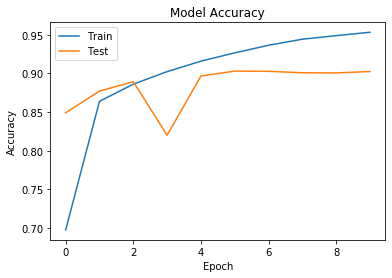

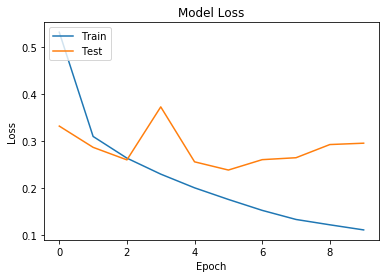

In [22]:
# Plot model's accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Test"], loc="upper left")
plt.show()

# Plot model's loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Test"], loc="upper left")
plt.show()

## 6. Conclusions <a id="Conclusions"/>

This notebook presented the use of a LSTM Neural Network for performing Sentiment Analysis on reviews from Twitter. The presented model resulted in an accuracy of 90.36%.

One of the key take aways was that the removal of stop words from the reviews did not enhance the model's performance, but on the contrary, led to a worse result.